# Virtual Dark Field Imaging - Ti550

This notebook performs virtual dark field (VDF) mapping of a SPED dataset of a Ti550 specimen taken by Dr Ian MacLaren Dr Enrique Frutos-Myro.

## Data
This is a real SPED dataset from a sample provided by Timet
You should then set the `filepath` variable in the cell below to your download location.

The notebook uses the bragg_peaks in the file at:
https://drive.google.com/file/d/12AO5SKkH84Q6oGxTMN1vE8gpd2PGYMsS/view

## Acknowlegements

This notebook was made Ian MacLaren. Contact ian.maclaren@glasgow.ac.uk with any questions.

### Versioning

Last updated on 2025-11-13 with the current dev version of py4DSTEM v.0.14.19.  It is essential that you upgrade to the dev version from this date or any subsequent version for this to run.  Otherwise, digital_dark_field is missing one function definition for filter_by_position.

In [1]:
# Main 4DSTEM analysis
import py4DSTEM
from py4DSTEM import show
from py4DSTEM.process.diffraction.digital_dark_field import (
    pointlist_to_array,
    aperture_array_generator, 
    DDFimage,
    filter_by_position
)
print(py4DSTEM.__version__)

# Calculations
import numpy as np

# Plotting
import matplotlib.pyplot as plt

0.14.19


# Load raw peak positions and check calibrations

In [2]:
# Note - change the file path to your own local path
filepath = '/local/scratch/Teaching/DDF_example/'

In [3]:
basename = 'Ti550_005'

In [4]:
# minor hack of the filename for saving
filename_braggpeaks = basename+'_bp_lattice.h5'

In [5]:
# Optional reload to pick up previously saved data for reprocessing
bragg_peaks = py4DSTEM.read(
    filepath+filename_braggpeaks, 
    root = '/datacube_root/braggvectors'
)

Reading PointListArray: 100%|██████████| 19100/19100 [00:02<00:00, 6621.38PointList/s]


In [6]:
# Check calibration - should be just 1 and pixels
bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      1
             R_pixel_size:      3
             Q_pixel_units:     pixels
             R_pixel_units:     nm
             QR_flip:           False
             _root_treepath:    
             probe_semiangle:   5.8014515793231265
             qx0_mean:          125.17372539856156
             qy0_mean:          125.82705778422975
)

# Diffraction pattern centering

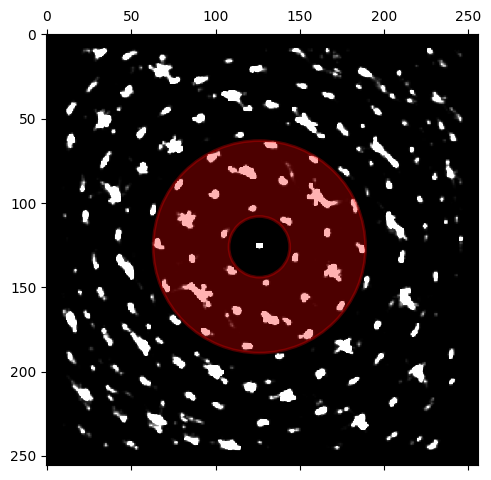

In [7]:
# Guess the center coordinate, specify the radial range for fitting peak pairs
center_guess = (126,126)
radial_range = (18,63)

# Show the ADF detector, overlaid over a new BVM
bragg_vector_map = bragg_peaks.get_bvm(mode='raw')
py4DSTEM.show(
    bragg_vector_map, 
    intensity_range='absolute',
    vmin=0,
    vmax=1000,
    annulus = {
      'center':center_guess,
      'radii' : radial_range,
      'alpha':0.3,
      'fill':True
    },
    figsize=(5,5)
)

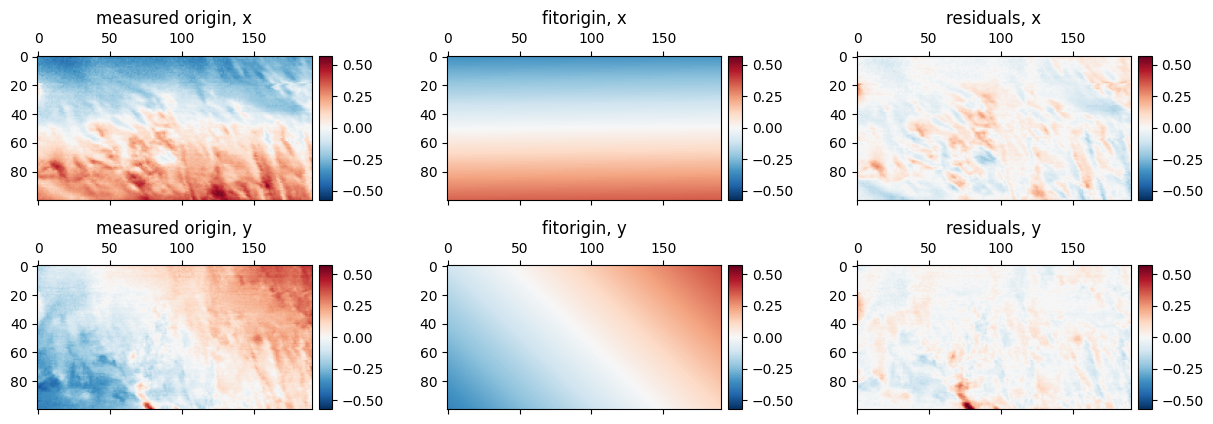

In [8]:
# Compute the origin position for all probe positions.
# This algorithm works by searching for peak pairs (Friedel symmetry) and finding the mean position of these pairs.

qxy_origins = bragg_peaks.measure_origin(
    center_guess = center_guess,
)

# Fit a plane to the origins
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin()

In [9]:
# apply the calibration
bragg_peaks.calibration.set_origin((qx0_fit, qy0_fit))
bragg_peaks.calibrate()

# Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks.get_bvm()
bragg_vector_map_cali = bragg_vector_map_centered

### Check before and after on centering

In [10]:
bvm_r = bragg_peaks.histogram( mode='raw', sampling=32 )
bvm_c = bragg_peaks.histogram( mode='cal', sampling=32 )                             

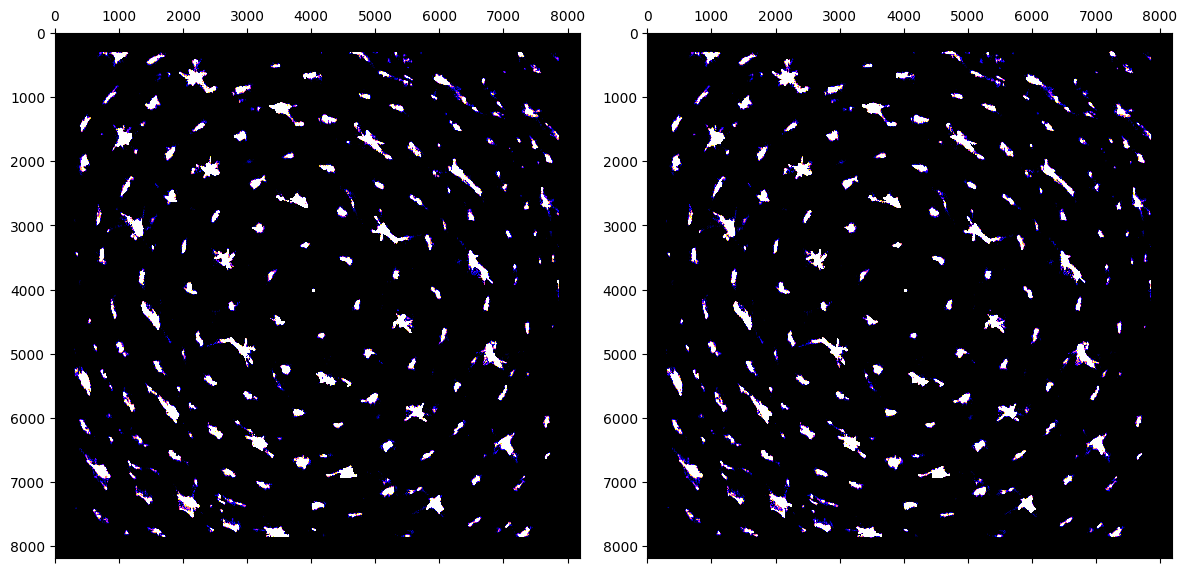

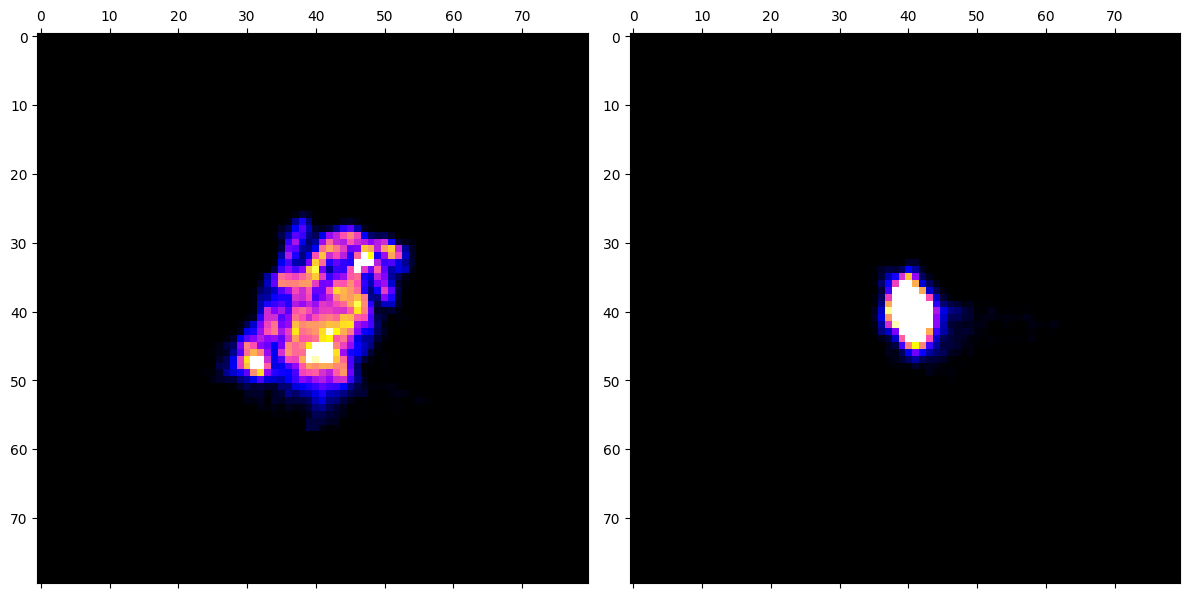

In [11]:
# show
py4DSTEM.show(
    [bvm_r, bvm_c],
    intensity_range='absolute',
    cmap='gnuplot2',
    vmin=0,
    vmax=1
)

# show, zooming in on origin
L = 40
x,y = bvm_c.origin
import numpy as np
x0,xf = np.round([x-L,x+L]).astype(int)
y0,yf = np.round([y-L,y+L]).astype(int)

py4DSTEM.show(
    [
    bvm_r[x0:xf,y0:yf],
    bvm_c[x0:xf,y0:yf]
    ],
    intensity_range='absolute',
    cmap='gnuplot2',
    vmin=0,
    vmax=100000
)

# Rotation Calibration from prior calibration formula
If doing for your own dataset, you'll have to work out your own calibration formula for your detector and your scan rotation.

In [12]:
#Read the appropriate rotation for this dataset
scan_rotation = 5.777 #rad
calib_rot = scan_rotation - np.radians(51)
#Convert from radians to degrees and print
angle = np.degrees(calib_rot)
angle

279.9977182470766

In [13]:
bragg_peaks.calibration.set_QR_rotation_degrees( angle )
bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:          1
             R_pixel_size:          3
             Q_pixel_units:         pixels
             R_pixel_units:         nm
             QR_flip:               False
             _root_treepath:        
             probe_semiangle:       5.8014515793231265
             qx0_mean:              125.5002983404213
             qy0_mean:              125.98403977479863
             qx0_meas:              2D-array
             qy0_meas:              2D-array
             origin_meas_mask:      2D-array
             qx0:                   2D-array
             qx0_shift:             2D-array
             qy0:                   2D-array
             qy0_shift:             2D-array
             QR_rotation:           4.886882081482892
             QR_rotation_degrees:   279.9977182470766
)

# Digital Dark Field

## Convert to Points Array
### This is the slowest bit

This converts the bragg_peaks object to a numpy array.  This allows very fast calculations using the vectorisation possibilities of numpy, whereby simple calculations can be broadcast over a very large array and done in a fraction of a second.

In [14]:
pointsarray2 = pointlist_to_array(
    bragg_peaks,
    center=True, # essential to use center correction
    pixel=False, # set true if you wish to work in calibrated units
    ellipse=False, # optional, but doing this is cool in nanocrystalline
    rotate=True, # a good idea if you want to relate real space and crystal directions
    rphi=False # only needed for working in polar coordinates for nanocrystalline
    
)

100%|██████████| 19100/19100 [00:38<00:00, 501.52it/s]


In [15]:
# Sanity check to find out how many diffraction datapoints we have
pointsarray2.shape

(656079, 5)

## BF image
#### Make a rough bright field image for use in navigation

#### Can construct with the standard function

In [16]:
aperturearraycentred0 = aperture_array_generator(
    shape = bragg_peaks.Qshape, # detector shape
    center = (bragg_peaks.Qshape[0]/2,bragg_peaks.Qshape[1]/2), #half the detector size is a good guess
    # center is only important if you want a non-centered array to overlay on 
    # diffraction pattern
    pad = 10, # Excludes anything within 10 pixels of the edge
    mode = 'single', # Just makes one aperture
    g1 = (1,0), # Doesn't matter what this is for just getting a zero
    g2 = (0,1), # Doesn't matter what this is for just getting a zero
    s1 = 0, # Zero lots of g1
    s2 = 0, # Zero lots of g2
    returns = 'centered' # Just the centered array is returned
)

In [17]:
# View the results
aperturearraycentred0

array([[0, 0]])

#### Make the image and display

In [18]:
BF_DDF = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=aperturearraycentred0, 
    tol=2
)

100%|██████████| 1/1 [00:00<00:00, 26.11it/s]


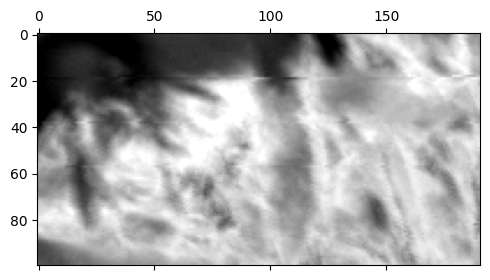

In [19]:
show(BF_DDF)

#### For something this simple, could just write it as a list
works just as well

In [20]:
aperturearraycentred0 = [0,0]

In [21]:
BF_DDF = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=aperturearraycentred0, 
    tol=2
)

100%|██████████| 2/2 [00:00<00:00, 27.62it/s]


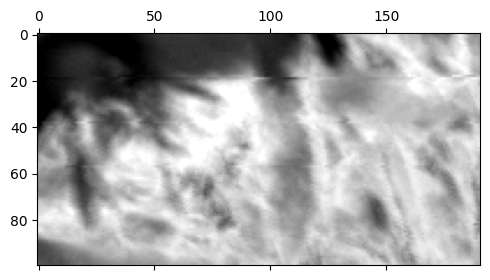

In [22]:
show(BF_DDF)

## Simple construction with just the points from one location (Rx,Ry) in the image

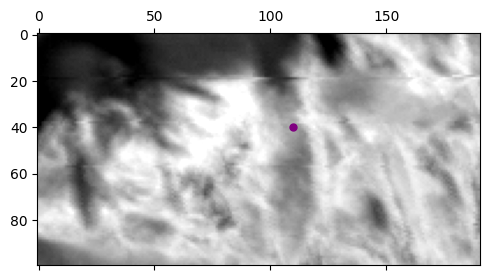

In [23]:
Rx1, Ry1, color, s = 40,110, 'purple', 10
show(
    BF_DDF,
    points = {
        'x': Rx1,
        'y': Ry1,
        's': s,
        'pointcolor': color
    }
)

#### Find the diffraction peak positions at probe position defined

In [24]:
points_pos1 = filter_by_position(pointsarray2, Rx1,Ry1)

In [25]:
# Look at the list
points_pos1

array([[ 4.57969332e+01, -8.16161847e+00],
       [ 1.38311827e-02, -2.22520902e-02],
       [-4.54072497e+01,  8.24101954e+00],
       [ 9.15208464e+01, -1.65276673e+01],
       [ 8.13308324e+01,  2.30035691e+01],
       [ 3.50704937e+01,  3.17157948e+01],
       [-1.09395360e+01,  3.96367921e+01],
       [ 1.10055234e+01, -3.95997011e+01],
       [-1.01319561e+02,  5.55878639e+01],
       [-3.47802223e+01, -3.16220686e+01],
       [-1.11946413e+02,  9.57286626e+01],
       [-9.05658667e+01,  1.67383419e+01],
       [ 5.69636056e+01, -4.80899906e+01],
       [-5.66527068e+01,  4.75878019e+01],
       [-8.03016469e+01, -2.31398888e+01],
       [-6.70882483e+01,  8.69621179e+01],
       [-2.20017447e+01,  7.85908215e+01],
       [ 7.04695673e+01,  6.26736237e+01],
       [ 2.37203752e+01,  7.06124335e+01],
       [ 1.03108488e+02, -5.63683887e+01],
       [ 1.38412647e+01,  1.10114900e+02]])

The lists are always ordered in decreasing intensity.  The zero item in the list is almost always the primary beam.  So you could just choose the brightest 5 or 10 excluding the primary beam (index 0).

In [27]:
Rx1Ry1shortlist = points_pos1[1:11]

In [28]:
Rx1Ry1image = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=Rx1Ry1shortlist, 
    tol=1
)

100%|██████████| 10/10 [00:00<00:00, 29.78it/s]


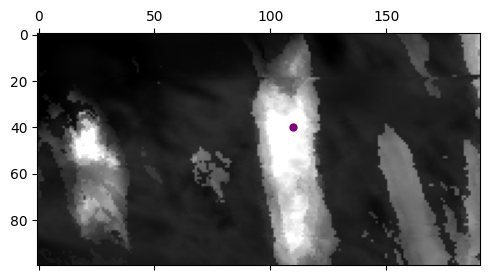

In [29]:
show(
    Rx1Ry1image,
    points = {
        'x': Rx1,
        'y': Ry1,
        's': s,
        'pointcolor': color
    }
)

#### This gives a great quick and dirty way of isolating crystals or a set of similarly oriented crystals
In this case, it isn't perfect because there are some spots in the diffraction pattern from the chosen scan pixel present in most diffraction patterns across the scan - to deal with that, we need to be more selective.  This happens here as all the features in this area came from the same single crystal at high temperature and all are crystallographically related (alpha-beta titanium alloy which was originally a single beta grain at high temperature).

## Plotting according to diffraction directions
Using tools already in the strain module

In [30]:
strainmap = py4DSTEM.StrainMap( braggvectors=bragg_peaks )


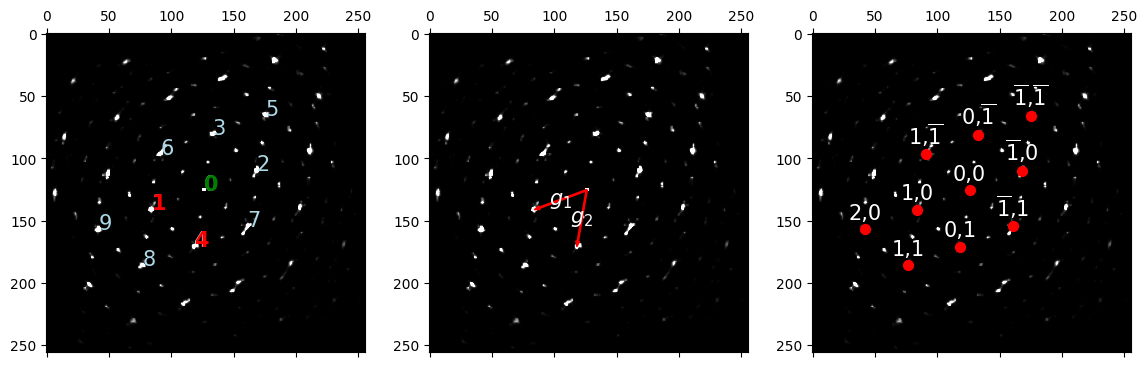

In [31]:
strainmap.choose_basis_vectors(
    minSpacing=4,
    minAbsoluteIntensity=1e6,
    maxNumPeaks=20,
    edgeBoundary=1,
    index_g1=1,
    index_g2=4,
    vis_params = {
        'vmin' : 0,
        'vmax' : 0.995
    }
)

### We need two sensible g vector choices

In [32]:
g1 = np.array(strainmap.g1)
g1

array([ 15.72163574, -42.06352129])

In [33]:
g2 = np.array(strainmap.g2)
g2

array([45.40339124, -7.93278277])

now we can use these to plot out some possible different arrays of spots to suit this area, which is all containing crystals with some spots in common

### Set up a little plotting function to allow comparison to the crystal spots 

In [34]:
def plot_filtarray_and_apertures(
    filteredarray, 
    aperturearraycentred, 
    c='blue',
    maxax=120,
    iscale=.03,
    ax=None
):
    if ax == None:
        fig,ax = plt.subplots(1,figsize=(6,6))
    else:
        pass
    ax.scatter(
        filteredarray[:,1],
        filteredarray[:,0],
        s=filteredarray[:,2]*iscale,c=c)
    ax.scatter(aperturearraycentred[:,1],aperturearraycentred[:,0],marker='o',ec='k',fc='none'),
    ax.set_ylim(maxax,-maxax)
    ax.set_xlim(-maxax,maxax)

### Choose a first set of apertures and make a DDF image

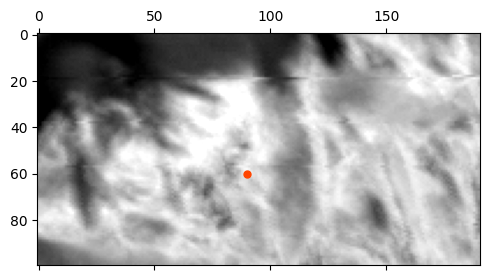

In [35]:
Rx2, Ry2, c2, s = 60,90, 'orangered', 10
show(
    BF_DDF,
    points = {
        'x': Rx2,
        'y': Ry2,
        's': s,
        'pointcolor': c2
    },
    cmap = 'grey'
)

In [36]:
# Find peaks for this positions
filt2 = filter_by_position(pointsarray2, Rx2, Ry2, intensity=True)
# Need to set intensity = True to get the intensities for the plotting function

In [37]:
aperturearraycentred2 = aperture_array_generator(
    bragg_peaks.Qshape, # diffraction pattern shape
    (127,127), # center position of detector in pixels
    10, # pad to exclude edge spots
    'array', # mode - in this case we are selecting an array
    g1, g2, # the basis vectors
    n1lims=(-3,3), n2lims=(-3,3), 
    s1 = 0, s2 = 0, # The shifts off-centre of the lattice
    r1=5, r2=80, # minimum and maximum radii for spots from centre
    returns='centered' # Just the centered dataset (only need the other 
    # for overlay on actual diffraction patterns)
)

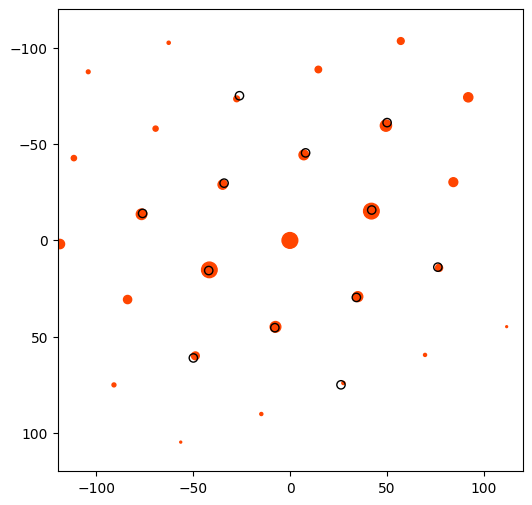

In [38]:
plot_filtarray_and_apertures(
    filt2,
    aperturearraycentred2,
    c='orangered',
    iscale=.1
)

In [39]:
pointslist2image = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=aperturearraycentred2, 
    tol=2
)

100%|██████████| 12/12 [00:00<00:00, 30.32it/s]


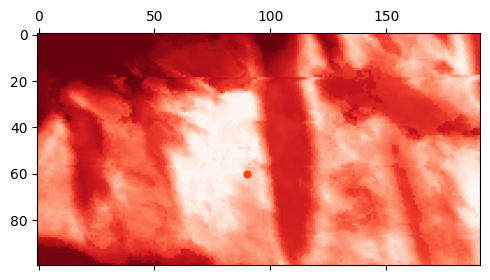

In [40]:
show(
    pointslist2image,
    points = {
        'x': Rx2,
        'y': Ry2,
        's': s,
        'pointcolor': c2
    },
    cmap = 'Reds_r'
)

A lot of areas show up bright and this happens because most areas have diffraction spots near these positions (even if positions move a little)

### Choose a second set of apertures and make a DDF image

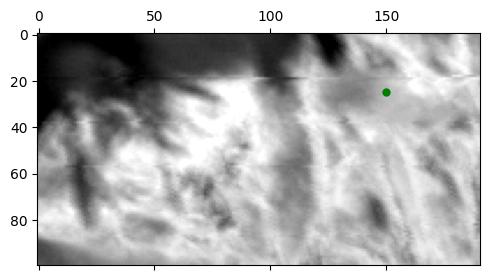

In [41]:
Rx3, Ry3, c3, s = 25,150, 'green', 10
show(
    BF_DDF,
    points = {
        'x': Rx3,
        'y': Ry3,
        's': s,
        'pointcolor': c3
    },
    cmap = 'grey'
)

In [42]:
# Find peaks for this positions
filt3 = filter_by_position(pointsarray2, Rx3, Ry3,intensity=True)

In [43]:
aperturearraycentred3 = aperture_array_generator(
    bragg_peaks.Qshape, # diffraction pattern shape
    (127,127), # center position of detector in pixels
    10, # pad to exclude edge spots
    'array', # mode - in this case we are selecting an array
    g1, g2, # the basis vectors
    n1lims=(-5,5), n2lims=(-5,5), 
    s1 = 0, s2 = 1/2, # The shifts off-centre of the lattice
    r1=5, r2=100, # minimum and maximum radii for spots from centre
    returns='centered' # Just the centered dataset (only need the other 
    # for overlay on actual diffraction patterns)
)

This picks out 1/2 spacing spots along the g2 direction.

These show the 0002 plane direction for the hexagonal alpha titanium laths

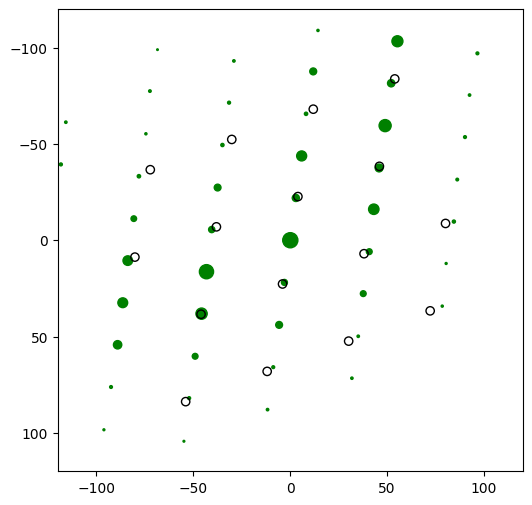

In [44]:
plot_filtarray_and_apertures(
    filt3,
    aperturearraycentred3,
    c='green',
    iscale=.1
)

fit is not perfect.  The g vectors were determined globally but don't seem to fit this area perfectly - you could adjust them a bit (which will be done below), but it may not be necessary because tolerance may be enough to allow the matching anyway.

In [45]:
pointslist3image = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=aperturearraycentred3, 
    tol=2
)

100%|██████████| 16/16 [00:00<00:00, 30.96it/s]


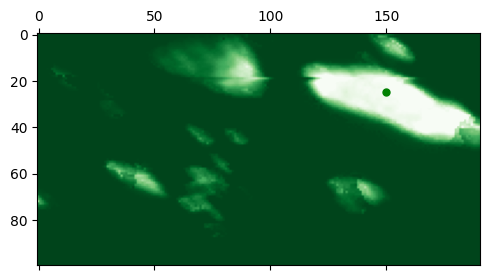

In [46]:
show(
    pointslist3image,
    points = {
        'x': Rx3,
        'y': Ry3,
        's': s,
        'pointcolor': c3
    },
    cmap = 'Greens_r'
)

imaging already works without adjustment of spot positions with a tolerance of 2 pixels

In [48]:
aperturearraycentred3b = aperture_array_generator(
    bragg_peaks.Qshape, # diffraction pattern shape
    (127,127), # center position of detector in pixels
    10, # pad to exclude edge spots
    'array', # mode - in this case we are selecting an array
    1.04*g1, 0.98*(g2-0.05*g1), # the basis vectors, adjusted
    n1lims=(-5,5), n2lims=(-5,5), 
    s1 = 0, s2 = 1/2, # The shifts off-centre of the lattice
    r1=5, r2=100, # minimum and maximum radii for spots from centre
    returns='centered' # Just the centered dataset (only need the other 
    # for overlay on actual diffraction patterns)
)

Here we just adjusted by hand and guesswork.  

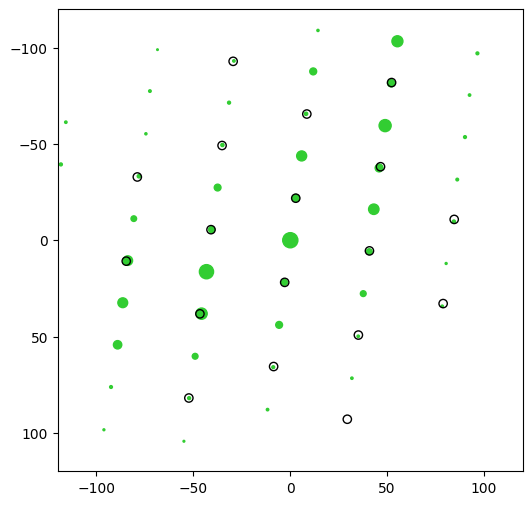

In [49]:
plot_filtarray_and_apertures(
    filt3,
    aperturearraycentred3b,
    c='limegreen',
    iscale=.1
)

better!

In [50]:
pointslist3bimage = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=aperturearraycentred3b, 
    tol=1
)
# Can now set a tighter tolerance

100%|██████████| 18/18 [00:00<00:00, 31.51it/s]


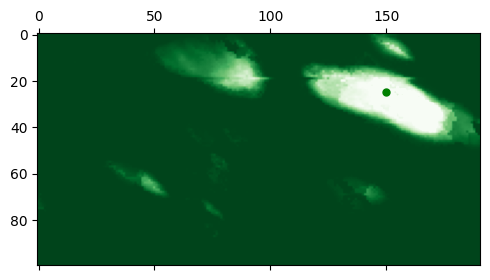

In [51]:
show(
    pointslist3bimage,
    points = {
        'x': Rx3,
        'y': Ry3,
        's': s,
        'pointcolor': c3
    },
    cmap = 'Greens_r'
)

fewer brighter areas in the map - so maybe more selective
You can go much further into tuning basis vectors if it is important.  This is done in our work on using DDF imaging with HOLZ reflections (where the long distances to the HOLZ mean even small errors in the basis vectors have a big effect - https://arxiv.org/abs/2504.18171). This uses a routine with scipy.optimize.

### Choose a third set of apertures and make a DDF image

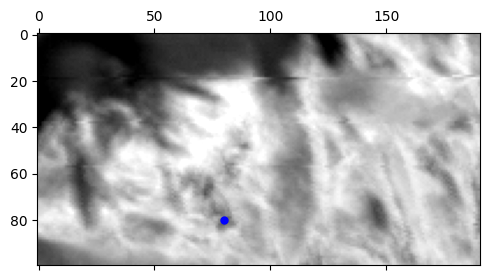

In [52]:
Rx4, Ry4, c4, s = 80,80, 'blue', 10
show(
    BF_DDF,
    points = {
        'x': Rx4,
        'y': Ry4,
        's': s,
        'pointcolor': c4
    },
    cmap = 'grey'
)

In [53]:
# Find peaks for this positions
filt4 = filter_by_position(pointsarray2, Rx4, Ry4, intensity=True)

In [54]:
aperturearraycentred4 = aperture_array_generator(
    bragg_peaks.Qshape, # diffraction pattern shape
    (127,127), # center position of detector in pixels
    10, # pad to exclude edge spots
    'array', # mode - in this case we are selecting an array
    g1, g2, # the basis vectors
    n1lims=(-5,5), n2lims=(-5,5), 
    s1 = 1/2, s2 = 0, # The shifts off-centre of the lattice
    r1=5, r2=100, # minimum and maximum radii for spots from centre
    returns='centered' # Just the centered dataset (only need the other 
    # for overlay on actual diffraction patterns)
)

This picks out half spacing spots along the g1 direction.

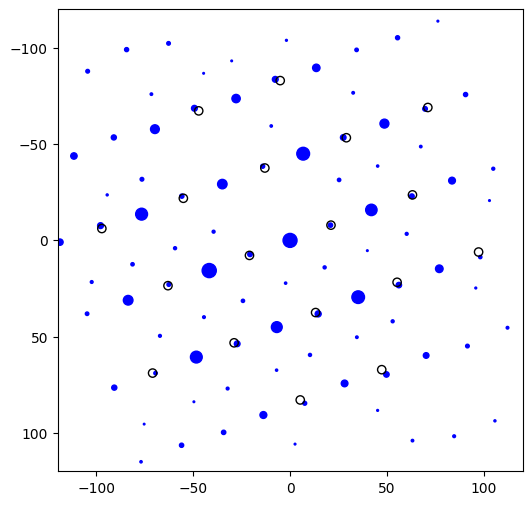

In [55]:
plot_filtarray_and_apertures(
    filt4,
    aperturearraycentred4,
    c='blue',
    iscale=.1    
)

again fits not perfect and could be adjusted, but close enough for now

In [56]:
pointslist4image = DDFimage(
    points_array=pointsarray2, 
    aperture_positions=aperturearraycentred4, 
    tol=2
)

100%|██████████| 18/18 [00:00<00:00, 31.19it/s]


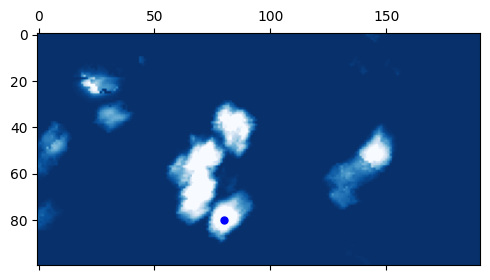

In [57]:
show(
    pointslist4image,
    points = {
        'x': Rx4,
        'y': Ry4,
        's': s,
        'pointcolor': c4
    },
    cmap = 'Blues_r'
)